In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import struct
import tensorflow as tf
from sklearn.model_selection import train_test_split

Завантаження набору та створення валідаційного набору

In [36]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 784)
        images = (images / 255.)
 
    return images, labels

In [37]:
X_train, y_train = load_mnist('', kind='train')
print('Train rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))
X_test, y_test = load_mnist('', kind='t10k')
print('Test rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Train rows: 60000, columns: 784
Test rows: 10000, columns: 784


In [38]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [39]:
y_train = tf.one_hot(y_train, depth=10)
y_test = tf.one_hot(y_test, depth=10)
y_val = tf.one_hot(y_val, depth=10)

In [40]:
y_train_graph = np.argmax(y_train, axis=1)
y_test_graph = np.argmax(y_test, axis=1)
y_val_graph = np.argmax(y_val, axis=1)

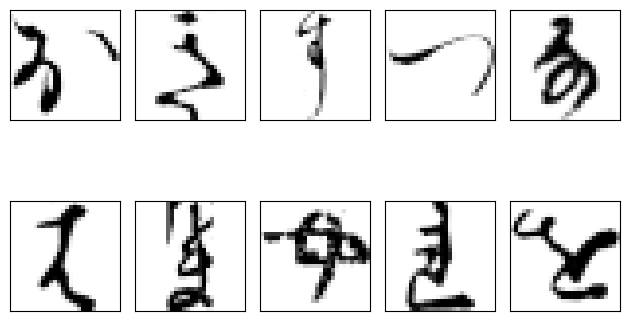

In [41]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train_graph == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [43]:
X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)
X_val = tf.cast(X_val, dtype=tf.float32)
y_val = tf.cast(y_val, dtype=tf.float32)

In [44]:
def plot_metrics(losses_list, accuracies_list, titles):
    num_plots = len(losses_list)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for i in range(num_plots):
        train_losses, val_losses = losses_list[i]
        title = titles[i]
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, label="Training Loss - " + title)
        
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("All Losses")

    plt.subplot(1, 2, 2)
    for i in range(num_plots):
        train_accuracies, val_accuracies = accuracies_list[i]
        title = titles[i]
        epochs = range(1, len(train_accuracies) + 1)
        plt.plot(epochs, train_accuracies, label="Training Accuracy - " + title)
        
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("All Accuracies")

    plt.show()
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    for i in range(num_plots):
        train_losses, val_losses = losses_list[i]
        title = titles[i]
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, val_losses, label="Validation Loss - " + title)
        
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("All Losses")

    plt.subplot(1, 2, 2)
    for i in range(num_plots):
        train_accuracies, val_accuracies = accuracies_list[i]
        title = titles[i]
        epochs = range(1, len(train_accuracies) + 1)
        plt.plot(epochs, val_accuracies, label="Validation Accuracy - " + title)
        
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("All Accuracies")

    plt.show()

In [66]:
def plot_wrong(x_test, y_test, model):
    predictions = model(x_test)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = y_test_graph

    misclassified = np.where(predicted_labels != true_labels)[0]

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()

    for i in range(0, 16):
        index = misclassified[i]
        axes[i].imshow(x_test[index].reshape(28, 28), cmap="gray")
        axes[i].set_title(f"True: {true_labels[index]}, Predicted: {predicted_labels[index]}", fontsize=12)
        plt.subplots_adjust(hspace=1)
        axes[i].axis("off")

    plt.show()

Мережа з одним вихідним шаром softmax

In [46]:
class SimpleNN(tf.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.w1 = tf.Variable(tf.random.normal([input_size, output_size], stddev=0.1, dtype=tf.float32))
        self.b1 = tf.Variable(tf.zeros([output_size]), dtype=tf.float32)
        self.l1_reg = 0.01

    def __call__(self, x):
        logits = tf.matmul(x, self.w1) + self.b1
        return tf.nn.softmax(logits)

    def loss_function(self, y_true, y_pred):
        return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred)) + self.l1_reg * tf.reduce_sum(tf.abs(self.w1)) 

input_size = X_train.shape[1] 
output_size = np.unique(y_train_graph).shape[0]

Алгоритм зворотного розповсюдження помилки (back propagation)

In [47]:
@tf.function
def train_step(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(outputs, model(inputs)))
    
    gradients = tape.gradient(loss, model.trainable_variables)

    for v, g in zip(model.trainable_variables, gradients):
        v.assign_sub(learning_rate * g)

    return loss

Виведення втрат та точності тестового набору

In [49]:
def metrics(model, X_test, y_test):
    predictions = model(X_test)
    loss = model.loss_function(y_test, predictions)
    correct_predictions = tf.equal(tf.argmax(predictions, 1), tf.argmax(y_test, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return loss.numpy(), accuracy.numpy()

Навчання моделі

In [50]:
def fit(model, learning_rate, epochs, batch_size, X_train, y_train, X_val, y_val):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        epoch_losses, epoch_accuracies = [], []

        for i in range(0, len(X_train), batch_size):
            x_batch = X_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            epoch_losses.append(train_step(model, x_batch, y_batch, learning_rate).numpy())
            batch_predictions = model(x_batch)
            correct_predictions = tf.equal(tf.argmax(batch_predictions, 1), tf.argmax(y_batch, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
            epoch_accuracies.append(accuracy.numpy())

        val_predictions = model(X_val)
        val_correct_predictions = tf.equal(tf.argmax(val_predictions, 1), tf.argmax(y_val, 1))
        train_losses.append(np.mean(epoch_losses))
        val_losses.append(model.loss_function(y_val, val_predictions).numpy())
        train_accuracies.append(np.mean(epoch_accuracies))
        val_accuracies.append(tf.reduce_mean(tf.cast(val_correct_predictions, tf.float32)).numpy())
        
        if not ((epoch+1) % 10): 
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")
            
    return train_losses, val_losses, train_accuracies, val_accuracies

In [51]:
learning_rate = 0.1
epochs = 50
batch_size = 32

model_single = SimpleNN(input_size, output_size)

loss_acc_single = fit(model_single, learning_rate, epochs, batch_size, X_train, y_train, X_val, y_val)

Epoch 10/50, Loss: 0.5684626698493958, Validation Loss: 0.6259572505950928
Epoch 20/50, Loss: 0.5538256764411926, Validation Loss: 0.6321976780891418
Epoch 30/50, Loss: 0.5465640425682068, Validation Loss: 0.6381090879440308
Epoch 40/50, Loss: 0.5419619679450989, Validation Loss: 0.6431541442871094
Epoch 50/50, Loss: 0.5387084484100342, Validation Loss: 0.6474623084068298


In [52]:
print(f"Test Loss: {metrics(model_single, X_test, y_test)[0]}\nTest Accuracy:{metrics(model_single, X_test, y_test)[1]}")

Test Loss: 1.112382173538208
Test Accuracy:0.6873000264167786


Модель з кількома прихованими шарами

In [53]:
class MultiLayerNN(tf.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation="relu"):
        super(MultiLayerNN, self).__init__()
        self.Ws = []
        self.biases = []
        self.activation = activation
        self.l1_reg = 0.01
        
        sizes = [input_size] + hidden_sizes + [output_size]

        for i in range(len(sizes) - 1):
            self.Ws.append(tf.Variable(tf.random.normal([sizes[i], sizes[i+1]], stddev=0.1)))
            self.biases.append(tf.Variable(tf.zeros([sizes[i+1]])))

    def __call__(self, x):
        layer_output = x
        for i in range(len(self.Ws) - 1):
            if self.activation == "relu":
                layer_output = tf.nn.relu(tf.matmul(layer_output, self.Ws[i]) + self.biases[i])
            
            if self.activation == "leaky_relu":
                layer_output = tf.nn.leaky_relu(tf.matmul(layer_output, self.Ws[i]) + self.biases[i])
            
            if self.activation == "elu":
                layer_output = tf.nn.elu(tf.matmul(layer_output, self.Ws[i]) + self.biases[i])
        layer_output = tf.matmul(layer_output, self.Ws[-1]) + self.biases[-1]
        return tf.nn.softmax(layer_output)
    
    def loss_function(self, y_true, y_pred):
        return tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, y_pred)) + self.l1_reg*tf.reduce_sum(tf.abs(self.Ws))

In [54]:
learning_rate = 0.1
epochs = 50
batch_size = 32
hidden_sizes = [128, 64]

model_multi = MultiLayerNN(input_size, hidden_sizes, output_size)

loss_acc_multi = fit(model_multi, learning_rate, epochs, batch_size, X_train, y_train, X_val, y_val)

Epoch 10/50, Loss: 0.016977868974208832, Validation Loss: 0.23336414992809296
Epoch 20/50, Loss: 0.0015487323980778456, Validation Loss: 0.27079230546951294
Epoch 30/50, Loss: 0.0009666383266448975, Validation Loss: 0.2852500081062317
Epoch 40/50, Loss: 0.0007874051807448268, Validation Loss: 0.2940780818462372
Epoch 50/50, Loss: 0.0007017396274022758, Validation Loss: 0.3006784915924072


In [55]:
print(f"Test Loss: {metrics(model_multi, X_test, y_test)[0]}\nTest Accuracy:{metrics(model_multi, X_test, y_test)[1]}")

Test Loss: 0.8065299987792969
Test Accuracy:0.8819000124931335


Різні значення швидкостi навчання.

In [68]:
learning_rate = 0.05
epochs = 50
batch_size = 32

model_test = SimpleNN(input_size, output_size)

loss_acc_test = fit(model_test, learning_rate, epochs, batch_size, X_train, y_train, X_val, y_val)
print(f"Test Loss: {metrics(model_test, X_test, y_test)[0]}\nTest Accuracy:{metrics(model_test, X_test, y_test)[1]}")

Epoch 10/50, Loss: 0.569653332233429, Validation Loss: 0.6136074662208557
Epoch 20/50, Loss: 0.5523450970649719, Validation Loss: 0.6142860651016235
Epoch 30/50, Loss: 0.5438473224639893, Validation Loss: 0.6173597574234009
Epoch 40/50, Loss: 0.5383608341217041, Validation Loss: 0.6205877661705017
Epoch 50/50, Loss: 0.5343946218490601, Validation Loss: 0.6236155033111572
Test Loss: 1.0665826797485352
Test Accuracy:0.6899999976158142


In [69]:
learning_rate = 0.01
epochs = 50
batch_size = 32

model_test = SimpleNN(input_size, output_size)

loss_acc_test = fit(model_test, learning_rate, epochs, batch_size, X_train, y_train, X_val, y_val)
print(f"Test Loss: {metrics(model_test, X_test, y_test)[0]}\nTest Accuracy:{metrics(model_test, X_test, y_test)[1]}")

Epoch 10/50, Loss: 0.6180815696716309, Validation Loss: 0.6342273950576782
Epoch 20/50, Loss: 0.5856091976165771, Validation Loss: 0.6161445379257202
Epoch 30/50, Loss: 0.5712295770645142, Validation Loss: 0.6101074814796448
Epoch 40/50, Loss: 0.5624474883079529, Validation Loss: 0.6074331998825073
Epoch 50/50, Loss: 0.5562702417373657, Validation Loss: 0.6061984300613403
Test Loss: 1.025423288345337
Test Accuracy:0.6967999935150146


In [70]:
learning_rate = 0.001
epochs = 50
batch_size = 32

model_test = SimpleNN(input_size, output_size)

loss_acc_test = fit(model_test, learning_rate, epochs, batch_size, X_train, y_train, X_val, y_val)
print(f"Test Loss: {metrics(model_test, X_test, y_test)[0]}\nTest Accuracy:{metrics(model_test, X_test, y_test)[1]}")

Epoch 10/50, Loss: 0.8664904236793518, Validation Loss: 0.8560112118721008
Epoch 20/50, Loss: 0.746940016746521, Validation Loss: 0.7480198740959167
Epoch 30/50, Loss: 0.6995007991790771, Validation Loss: 0.7059009075164795
Epoch 40/50, Loss: 0.672622799873352, Validation Loss: 0.6828982830047607
Epoch 50/50, Loss: 0.6547602415084839, Validation Loss: 0.668157160282135
Test Loss: 1.0975333452224731
Test Accuracy:0.6636999845504761


Найкращим параметром швидкості навчання є 0.01 з точністю 0.6967999935150146

Графiки змiни функцiї втрат; графiки змiни  accuracy

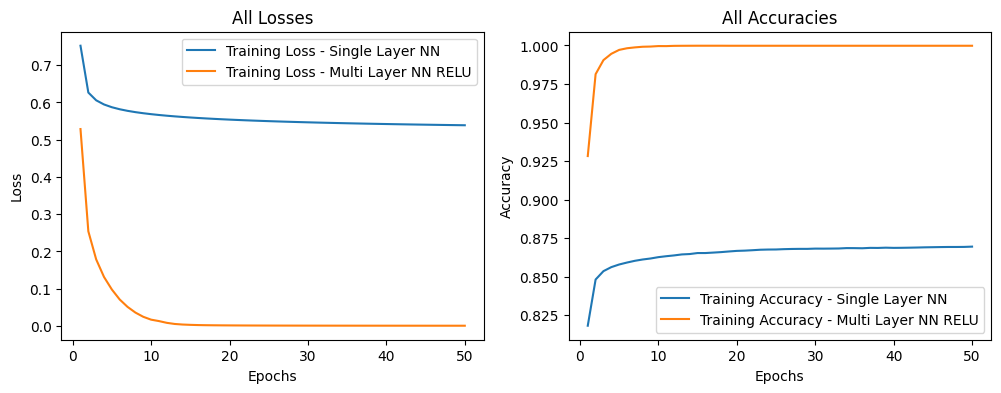

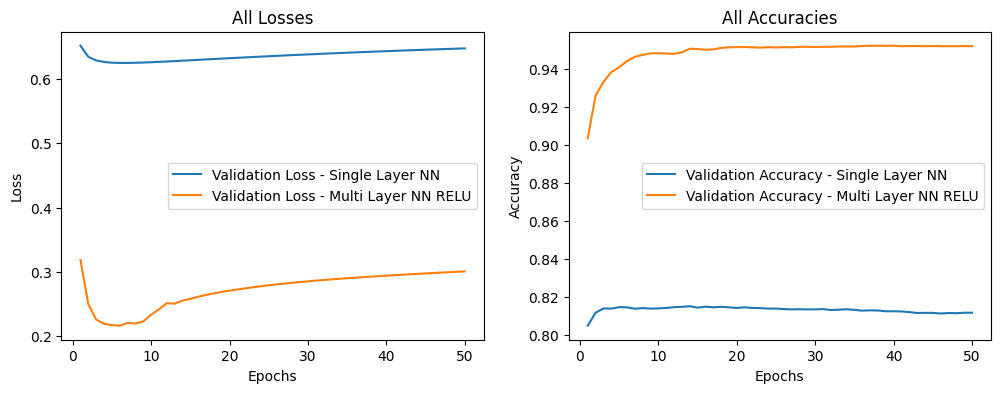

In [58]:
losses = [
[loss_acc_single[0], loss_acc_single[1]],
[loss_acc_multi[0], loss_acc_multi[1]]
]
accuracires = [
[loss_acc_single[2], loss_acc_single[3]],
[loss_acc_multi[2], loss_acc_multi[3]]
]
titles = [
"Single Layer NN",
"Multi Layer NN RELU",
]
plot_metrics(losses, accuracires, titles)

Неправильно класифіковані зображення

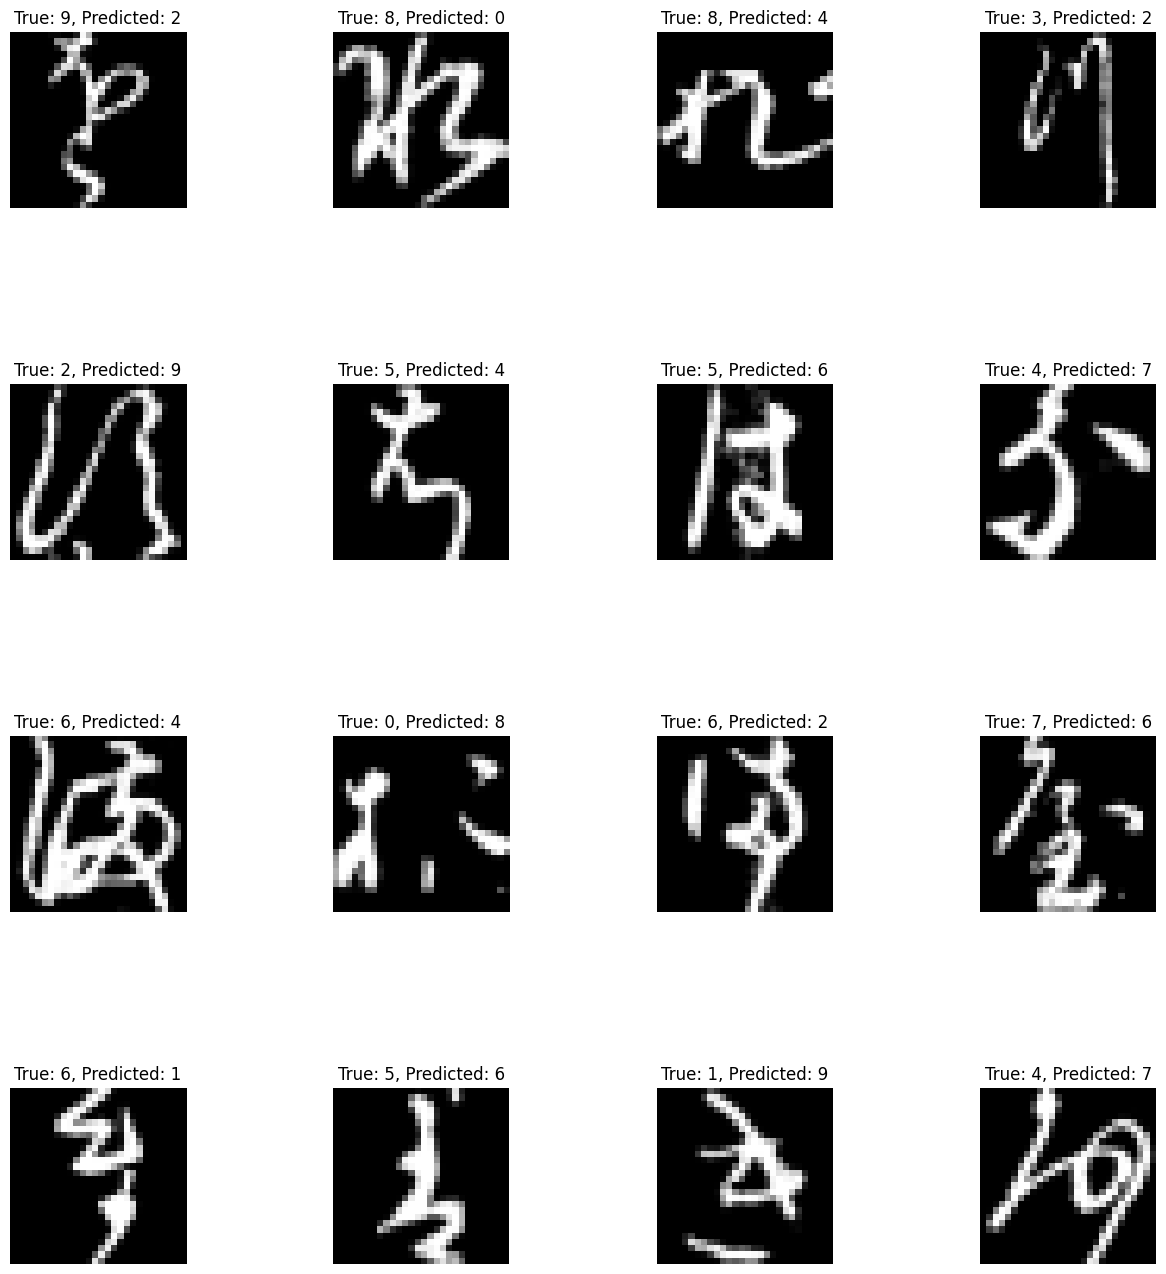

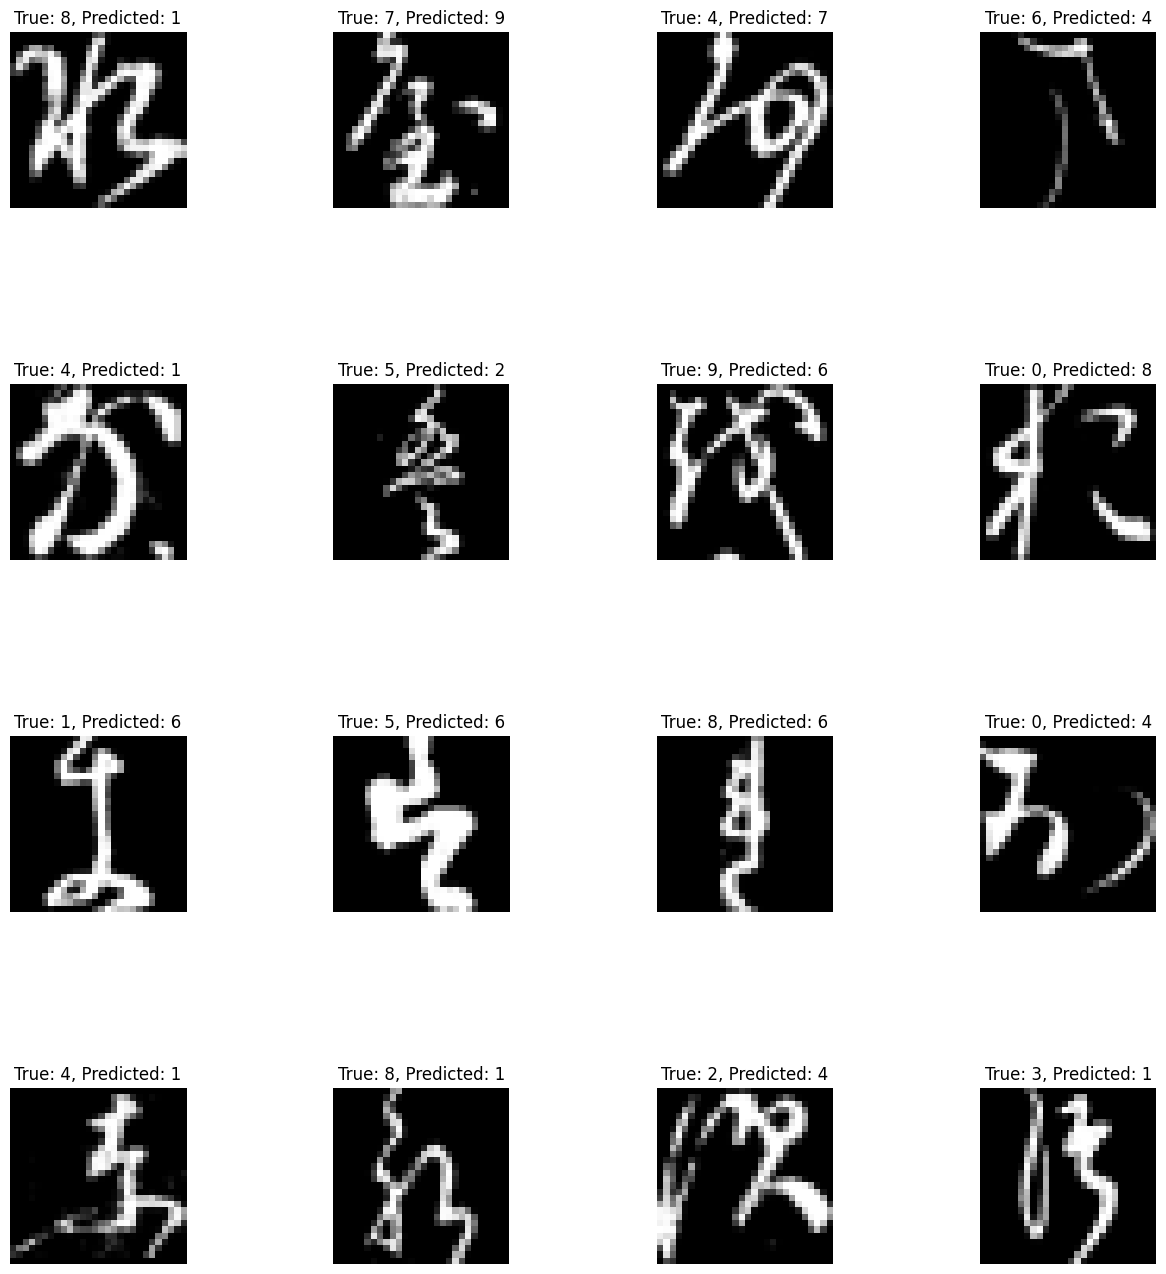

In [67]:
plot_wrong(X_test, y_test, model_single)

plot_wrong(X_test, y_test, model_multi)

Різні функції активації

In [60]:
learning_rate = 0.1
epochs = 50
batch_size = 32

model_multi_leaky = MultiLayerNN(input_size, hidden_sizes, output_size, activation="leaky_relu")

loss_acc_leaky = fit(model_multi_leaky, learning_rate, epochs, batch_size, X_train, y_train, X_val, y_val)

Epoch 10/50, Loss: 0.03922959044575691, Validation Loss: 0.2675299346446991
Epoch 20/50, Loss: 0.017696591094136238, Validation Loss: 0.2982950806617737
Epoch 30/50, Loss: 0.0009240065701305866, Validation Loss: 0.290522038936615
Epoch 40/50, Loss: 0.0007283783052116632, Validation Loss: 0.2981224060058594
Epoch 50/50, Loss: 0.000654586183372885, Validation Loss: 0.3033890426158905


In [61]:
print(f"Test Loss: {metrics(model_multi_leaky, X_test, y_test)[0]}\nTest Accuracy:{metrics(model_multi_leaky, X_test, y_test)[1]}")

Test Loss: 0.8034414649009705
Test Accuracy:0.8877999782562256


In [62]:
learning_rate = 0.1
epochs = 50
batch_size = 32

model_multi_elu = MultiLayerNN(input_size, hidden_sizes, output_size, activation="elu")

loss_acc_elu = fit(model_multi_elu, learning_rate, epochs, batch_size, X_train, y_train, X_val, y_val)

Epoch 10/50, Loss: 0.030000483617186546, Validation Loss: 0.22095780074596405
Epoch 20/50, Loss: 0.0021550769452005625, Validation Loss: 0.24420829117298126
Epoch 30/50, Loss: 0.0011702746851369739, Validation Loss: 0.2599326968193054
Epoch 40/50, Loss: 0.0009111174149438739, Validation Loss: 0.26929327845573425
Epoch 50/50, Loss: 0.000794305931776762, Validation Loss: 0.2757259011268616


In [63]:
print(f"Test Loss: {metrics(model_multi_elu, X_test, y_test)[0]}\nTest Accuracy:{metrics(model_multi_elu, X_test, y_test)[1]}")

Test Loss: 0.7493144273757935
Test Accuracy:0.8885999917984009


Швидкості:      
RELU: 3 хвилини 20 секунд       
LeakyRELU: 3 хвилини 29 секунд      
ELU: 3 хвилини 31 секунд        

Точності:       
RELU: 0.881       
LeakyRELU: 0.888      
ELU: 0.889        

In [64]:
losses = [
[loss_acc_multi[0], loss_acc_multi[1]],
[loss_acc_leaky[0], loss_acc_leaky[1]],
[loss_acc_elu[0], loss_acc_elu[1]]
]
accuracires = [
[loss_acc_multi[2], loss_acc_multi[3]],
[loss_acc_leaky[2], loss_acc_leaky[3]],
[loss_acc_elu[2], loss_acc_elu[3]]
]
titles = [
"Multi Layer NN RELU",
"Multi Layer NN Leaky RELU",
"Multi Layer NN ELU"
]

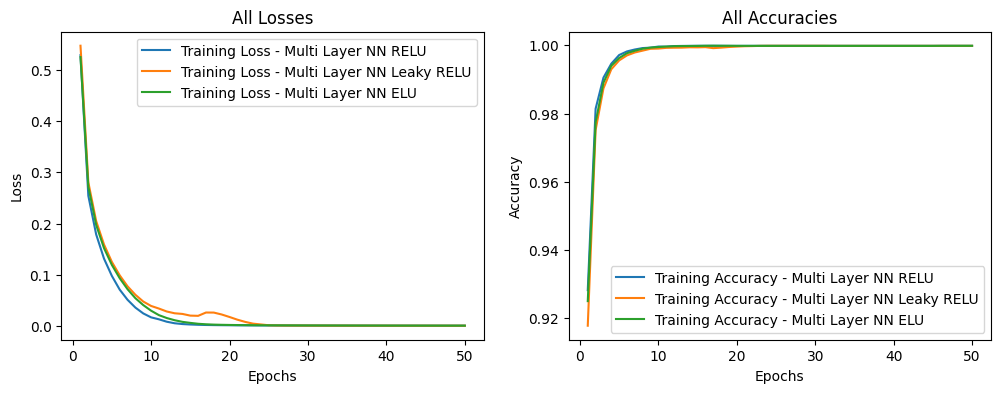

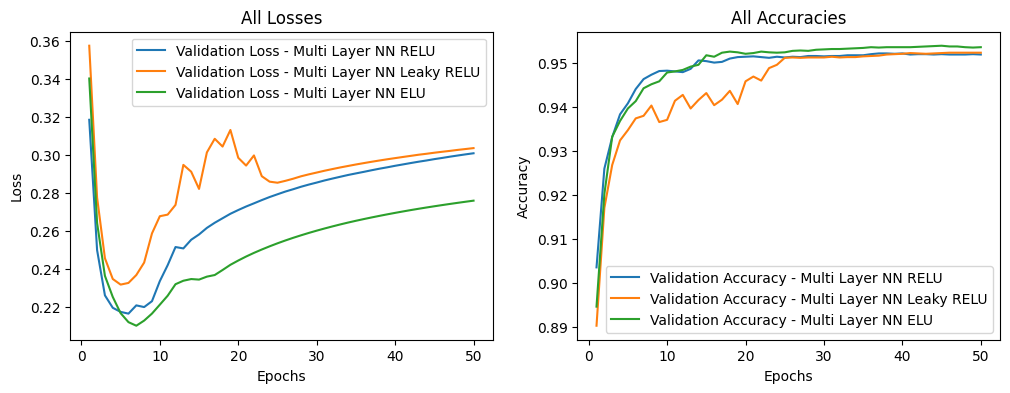

In [65]:
plot_metrics(losses, accuracires, titles)

Всі 3 моделі мають приблизно однаковий результат, як в часі навчання моделі, так і в точності на тестових даних